<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_misc_interpolation_integral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 補間と数値積分




In [35]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib

     |████████████████████████████████| 4.1 MB 5.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=d105a6530267a1b53e09b3b400a9f0d086918c428a2f6592d48b83e77b0b8d19
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


##補間

補間/内挿(interpolation)とは、既知の離散的な点列をもとに  
点列の間の各点の値を見積もったり、連続的な関数としての表現を与えることの総称である。

たとえば、夏休みの宿題でアサガオの観察日記をつけることにしたAさんが、  
毎日、アサガオの鉢の土の表面温度もあわせて記録していたとする。

ところが、お盆で祖父母の家に帰った3日だけ、測定をさぼってしまった。  
そんなとき、お盆前までとお盆以降の測定結果から  
お盆期間の温度を見積もることは、
[内挿]を考えていることに相当する。

### 線形補間

誰でもすぐに思いつく方法は、既知の点を直線で結んで間の点の値を補うことであり、  
これは線形補間や１次補間と呼ばれる。

線形になる機構がわかっている場合を除いて、測定し忘れたデータを線で補間した結果が正しい保証はまったくないのだが、とにかくやってみよう。

[気象庁の東京の2020年8月の気象データ](https://www.data.jma.go.jp/obd/stats/etrn/view/daily_s1.php?prec_no=44&block_no=47662&year=2020&month=8&day=&view=)から、最高気温を例にとってみよう。

手で入力するのではなく、スクレイピングしてみよう。
DataFrameの使い方については別のノートブックを参照のこと。




In [4]:
url = 'https://www.data.jma.go.jp/obd/stats/etrn/view/daily_s1.php?prec_no=44&block_no=47662&year=2020&month=8&day=&view='
df = pd.read_html(url)[0] #0番目がほしい表になっている

列を確認すると

In [5]:
print(df.columns) 

MultiIndex([(         '日',          '日',                '日', ...),
            (   '気圧(hPa)',         '現地',               '平均', ...),
            (   '気圧(hPa)',         '海面',               '平均', ...),
            (   '降水量(mm)',    '降水量(mm)',               '合計', ...),
            (   '降水量(mm)',    '降水量(mm)',               '最大', ...),
            (   '降水量(mm)',    '降水量(mm)',               '最大', ...),
            (     '気温(℃)',      '気温(℃)',               '平均', ...),
            (     '気温(℃)',      '気温(℃)',               '最高', ...),
            (     '気温(℃)',      '気温(℃)',               '最低', ...),
            (     '湿度(％)',      '湿度(％)',               '平均', ...),
            (     '湿度(％)',      '湿度(％)',               '最小', ...),
            ('風向・風速(m/s)', '風向・風速(m/s)',             '平均風速', ...),
            ('風向・風速(m/s)', '風向・風速(m/s)',             '最大風速', ...),
            ('風向・風速(m/s)', '風向・風速(m/s)',             '最大風速', ...),
            ('風向・風速(m/s)', '風向・風速(m/s)',           '最大瞬間風速', .

タプルになっていて少々厄介な構造になっていることが分かる。

In [6]:
df

日 気圧(hPa)         降水量(mm)  ... 雪(cm)                天気概況                 
     日      現地      海面 降水量(mm)  ... 雪(cm)                天気概況                 
     日      平均      平均      合計  ...    降雪 最深積雪 昼(06:00-18:00) 夜(18:00-翌日06:00)
     日      平均      平均      合計  ...    合計    値 昼(06:00-18:00) 夜(18:00-翌日06:00)
0    1  1009.3  1012.0     0.5  ...    --   --              晴             晴一時曇
1    2  1011.0  1013.8      --  ...    --   --           晴時々曇                晴
2    3  1011.0  1013.8      --  ...    --   --              晴                晴
3    4  1012.2  1014.9      --  ...    --   --              晴            晴後時々曇
4    5  1013.4  1016.1     0.0  ...    --   --              晴            晴後一時曇
5    6  1010.5  1013.2      --  ...    --   --          晴時々薄曇                晴
6    7  1005.0  1007.7      --  ...    --   --             薄曇             曇一時晴
7    8  1006.1  1008.8      --  ...    --   --            曇後晴             曇一時晴
8    9  1006.9  1009.6      --  ...    --   --             薄曇            薄曇時々晴
9   10  1010.3  1013.0      --  ...    --   --             薄曇            晴時々薄曇
10  11  1009.7  1012.4      --  ...    --   --              晴               快晴
11  12  1009.0  1011.7     0.5  ...    --   --    晴後曇一時雨、雷を伴う           曇一時雨後晴
12  13  1006.4  1009.1    21.5  ...    --   --  晴後時々曇一時雨、雷を伴う                晴
13  14  1005.5  1008.3     0.0  ...    --   --              晴            晴後一時曇
14  15  1004.0  1006.7      --  ...    --   --              晴             晴後薄曇
15  16  1006.2  1008.9     0.0  ...    --   --         晴、雷を伴う              曇後晴
16  17  1007.2  1009.9     0.0  ...    --   --          曇後一時晴             曇一時雨
17  18  1007.2  1009.9      --  ...    --   --           晴一時曇             曇時々晴
18  19  1008.3  1011.0      --  ...    --   --          晴時々薄曇            晴一時薄曇
19  20  1008.9  1011.6      --  ...    --   --              晴               快晴
20  21  1009.5  1012.3      --  ...    --   --              晴                晴
21  22  1008.5  1011.2     0.0  ...    --   --           晴時々曇        曇時々雨、雷を伴う
22  23  1006.2  1009.0    38.0  ...    --   --     曇時々大雨、雷を伴う          晴時々曇一時雨
23  24  1004.9  1007.7     0.0  ...    --   --           晴一時曇             曇一時晴
24  25  1007.7  1010.4      --  ...    --   --              晴                晴
25  26  1009.4  1012.1      --  ...    --   --              晴                晴
26  27  1009.7  1012.4     0.0  ...    --   --           晴一時雨            晴後時々曇
27  28  1009.3  1012.0      --  ...    --   --           晴一時曇                晴
28  29  1007.9  1010.6      --  ...    --   --              晴            薄曇時々晴
29  30  1007.1  1009.8      --  ...    --   --              晴             晴後薄曇
30  31  1008.3  1011.0     1.0  ...    --   --           曇時々晴             曇時々雨

[31 rows x 21 columns]

少々adhocだが、7列目に欲しいデータ(最高気温)があるのでndarrayにしてしまおう

In [15]:
highT = np.array(list(df.iloc[:,7]))
print(highT)

[31.8 31.5 32.3 33.1 34.2 33.1 35.4 32.3 34.7 35.2 37.3 35.8 36.1 34.2
 36.1 35.4 36.5 34.3 34.2 34.8 36.  35.2 29.4 32.3 32.2 34.  33.6 34.5
 35.  34.9 32.6]


毎日観測するのが大変なので偶数の日は観測をサボることにしたとしましょう。

In [37]:
import copy 
obsT = copy.copy(highT)
for i in range(1,31,2):
    obsT[i] = None
print("観測", obsT)

観測 [31.8  nan 32.3  nan 34.2  nan 35.4  nan 34.7  nan 37.3  nan 36.1  nan
 36.1  nan 36.5  nan 34.2  nan 36.   nan 29.4  nan 32.2  nan 33.6  nan
 35.   nan 32.6]


偶数の日は前後の日のデータを使って補間することにすると

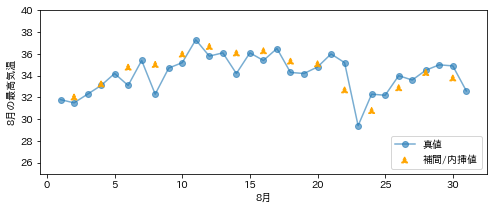

In [51]:
def lin_interp(x1,y1,x2,y2,x):
    return ((x-x1)*y2 - (x-x2)*y1)/ (x2-x1)
xr = np.array(range(31))
for i in range(1,31,2):
    x1 = xr[i-1]; y1 = highT[i-1]
    x2 = xr[i+1]; y2 = highT[i+1]
    obsT[i] = lin_interp(x1,y1,x2,y2,xr[i])

xr = xr + 1
fig = plt.figure(figsize=(8,3))
plt.ylim(25,40)
plt.xlabel("8月")
plt.ylabel("8月の最高気温")
plt.plot(xr,highT,marker="o",linestyle="-",alpha=0.6,label="真値",zorder=1)
plt.scatter(xr[1::2],obsT[1::2],marker="^",linestyle="dashed",
            label="補間/内挿値",color="orange",zorder=10)
plt.legend(loc="lower right")
plt.show()
plt.close()

となります。それっぽいデータが得られました。

### スプライン補間

### ラグランジュ補間

## 数値積分

###  台形公式

### シンプソンの公式

### $\clubsuit$ ガウス求積 (gaussian quadrature) $^{(*1)}$

任意の多項式関数$f(x)$について、区間$[-1,1]^{(*2)}$に渡る定積分$I$を、  
正の整数$n$を用いて、
$I = \int^1_{-1}f(x) \simeq \sum^n_{i=1}w_i f(x_i)$  
の形でなるべく正確に(実用的には、正確かつ少ない項数nで)近似する事を考える。

$x_i$は積分点(またはガウス点)、$w_i$は重みと呼ばれる。

ガウス求積というときは通常、後述のGauss-Legendre公式を指し、  
$n$次のルジャンドル多項式の$n$個の零点([-1,1]内にある)を積分点として選ぶ。  
このとき、$w_i$を(以降の小節のように)適切に選ぶと、$f(x)$が$2n-1$次以下の場合、等号が厳密に成り立つ。  
逆に、関数$f(x)$が$2n$以上の次数を持つ多項式の場合や、多項式関数でない場合、  
上の等号は成り立たない(近似の精度が十分な場合もある)。

>*1: ガウスに因んで名付けられた数値解析の手法で、  
物理などでよく出てくるガウス積分$\int^\infty_{-\infty} dx \exp{(-x^2)} = \sqrt{\pi}$とは特別関係はない

>*2 一般には、任意の区間$[a,b]$についての積分がしたくなるが、  
区間$[-1,1]$に"標準化"するのが慣例で、多くのライブラリ等での実装もそうなっている。  
このためにはもちろん、元の変数$x$を$t = \frac{2(x-a)}{b-a }- 1 $と 変数変換をすればよい。  
具体的な表式を書いておくと...
$\int^b_a dx f(x) = \frac{b-a}{2}\int^1_{-1}dt f(\frac{b-a}{2}t +\frac{a+b}{2})$となる。


### Gauss-Legendre公式

上記の$n$個の積分点を$n$次のLegendre多項式の零点、  
つまり$P_n(x_i)=0$となる点$x_i$(i=1,...,n)に取る。  
また重みを$w_i=2/[ nP_{n-1}(x_i) P'_{n}(x_i)]$と取る。

> このノートブックではルジャンドル多項式の性質を全て網羅することはしない。  
人生で一度くらいは工学や物理などで出てくる直交多項式の漸化式などを勉強しておくと良いかも...。  
ルジャンドル多項式, エルミート多項式，ラゲール多項式， etc.  
覚えておく必要はなく、必要になった時に「アレに載ってたな...」と思い出せれば良い。  
参考: [物理のための応用数学 (裳華房)][詳解応用物理数学演習 (共立出版)]

数値積分をしてみよう。

たとえば関数$f(x)= 7 x^6 + 20x^4 + 1$を考える。  
この関数の区間$[-1,1]$における積分の値は手計算で求めることができて  
$\int^1_{-1}dx (7x^6 + 20 x^4 + 1) = [ x^7 + 4x^5 + x ]^{x=1}_{x=-1}=12 $である。


In [ ]:
#関数を定義
def f(x):
    return 7 * x**6 + 20* x**4 + 1

ルジャンドル多項式の零点を求めるには、  
numpyの中にある関数を使えばよい。

In [ ]:
import numpy as np

In [ ]:
n=6

# 零点と重みを計算する
xs,ws = np.polynomial.legendre.leggauss(n)

print("次数",n);print("零点",xs);print("重み",ws)
# s = f(xs[0])*ws[0] + f(xs[1])*ws[1] + ...
s = np.dot(f(xs),ws) # numpyのブロードキャストで1行で書ける
print("数値積分の結果", s)

次数 6
零点 [-0.93246951 -0.66120939 -0.23861919  0.23861919  0.66120939  0.93246951]
重み [0.17132449 0.36076157 0.46791393 0.46791393 0.36076157 0.17132449]
数値積分の結果 11.999999999999979


In [ ]:
for n in range(1,6):
    xs,ws = np.polynomial.legendre.leggauss(n)
    print("n=",n, " 積分値 ", np.dot(f(xs),ws))

n= 1  積分値  2.0
n= 2  積分値  6.962962962962962
n= 3  積分値  11.680000000000003
n= 4  積分値  11.999999999999993
n= 5  積分値  12.00000000000001


次数を下げて$n=4$程度でも、つまりたった4つの積分点で  
積分値を高精度に近似できていることが分かる。
